# Classification using Random Forest
## Goal
 - Tune hyperparameters for Random Forest model

##  Conclusion
 - Final model has fairly high accuracy (0.91 for training and 0.91 for test)
 - Final model has decent recall (0.83 for training and 0.85 for test)
 - Precision on final model is ok (0.64 for training and 0.64 for test)

In [1]:
# Standard Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Models
from sklearn.ensemble import RandomForestClassifier

# Transformers
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from imblearn.over_sampling import SMOTE

# Model Evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import plot_confusion_matrix, f1_score, precision_score, recall_score

# Pipelines
from imblearn.pipeline import Pipeline

### Import Data

In [2]:
df = pd.read_csv('../../data/processed/churn_dataset.csv', index_col = 0)
X = df.drop(columns = 'churn')
y = df.churn

random_state = 45
cv = 5

### Calculate baseline F1-Score

In [3]:
X_train_all, X_hold_out, y_train_all, y_hold_out = train_test_split(X, y, random_state = random_state)
number_selector = make_column_selector(dtype_include='number')
string_selector = make_column_selector(dtype_include='object')
preprocessing = make_column_transformer((OneHotEncoder(handle_unknown='ignore'), string_selector),
                                        (StandardScaler(), number_selector),
                                        remainder='passthrough')
forest = RandomForestClassifier(random_state = random_state)
pipeline = Pipeline([('preprocessing', preprocessing),
                     ('sm', SMOTE(random_state = random_state)), 
                     ('rf', forest)])
pipeline.fit(X_train_all, y_train_all)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fdbdc217fa0>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fdbdc284220>)])),
                ('sm', SMOTE(random_state=45)),
                ('rf', RandomForestClassifier(random_state=45))])

In [4]:
train_preds = pipeline.predict(X_train_all)
hold_out_preds = pipeline.predict(X_hold_out)

train_f1 = f1_score(y_train_all, train_preds)
test_f1 = f1_score(y_hold_out, hold_out_preds)
print('Baseline Training F1-Score: {:.2f}'.format(train_f1))
print('Baseline Testing F1-Score: {:.2f}'.format(test_f1))

Baseline Training F1-Score: 1.00
Baseline Testing F1-Score: 0.76


### Tune Hyperparameters
- Use max_depth, min_samples_leaf and max_leaf_nodes from Decision Tree tuning

In [5]:
param_grid = {'rf__n_estimators':(25, 50, 75, 100, 125, 150),
              'rf__criterion':('gini', 'entropy'),
              'rf__max_depth':[5],
              'rf__min_samples_leaf':[50],
              'rf__max_leaf_nodes':[15],
              'rf__max_features':(None, 'auto', 'sqrt', 'log2'),
              'rf__oob_score':(True, False), 
              'rf__warm_start':(True, False)}
grid_search = GridSearchCV(pipeline, param_grid, scoring = 'f1')
grid_search.fit(X_train_all, y_train_all)

GridSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fdbdc217fa0>),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at...
                                       ('sm', SMOTE(random_state=45)),
                                       ('rf',
                                        RandomForestCla

In [6]:
print('Training F1-Score: {:.2f}'.format(grid_search.score(X_train_all, y_train_all)))
print('Test F1-Score: {:.2f}'.format(grid_search.score(X_hold_out, y_hold_out)))

Training F1-Score: 0.72
Test F1-Score: 0.73


In [7]:
grid_search.best_params_

{'rf__criterion': 'entropy',
 'rf__max_depth': 5,
 'rf__max_features': None,
 'rf__max_leaf_nodes': 15,
 'rf__min_samples_leaf': 50,
 'rf__n_estimators': 25,
 'rf__oob_score': True,
 'rf__warm_start': True}

### Instantiate final model

In [8]:
forest = RandomForestClassifier(random_state = random_state, 
                                criterion = 'entropy', max_depth = 5, 
                                max_features = None,
                                max_leaf_nodes = 15, min_samples_leaf = 50, 
                                n_estimators = 25, 
                                oob_score = True, warm_start = True)
pipeline = Pipeline([('preprocessing', preprocessing),
                     ('sm', SMOTE(random_state = random_state)), 
                     ('rf', forest)])
pipeline.fit(X_train_all, y_train_all)

train_preds = pipeline.predict(X_train_all)
hold_out_preds = pipeline.predict(X_hold_out)
train_f1 = f1_score(y_train_all, train_preds)
test_f1 = f1_score(y_hold_out, hold_out_preds)
print('Training F1-Score: {:.2f}'.format(train_f1))
print('Testing F1-Score: {:.2f}'.format(test_f1))

Training F1-Score: 0.72
Testing F1-Score: 0.73


### Check Confusion Matrices and Calculate Accuracy

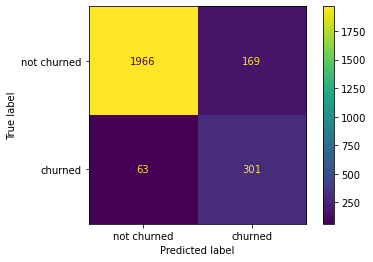

In [9]:
plot_confusion_matrix(pipeline, X_train_all, y_train_all, display_labels=['not churned', 'churned'])

In [10]:
print('Training Accuracy: {:.2f}'.format(pipeline.score(X_train_all, y_train_all)))
print('Training Recall: {:.2f}'.format(recall_score(y_train_all, train_preds)))
print('Training Precision: {:.2f}'.format(precision_score(y_train_all, train_preds)))

Training Accuracy: 0.91
Training Recall: 0.83
Training Precision: 0.64


***Notes***
- Training accuracy is fairly high
- Training recall is decent
- Training precision is ok

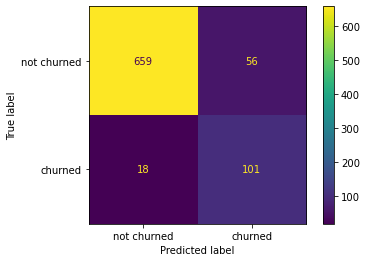

In [11]:
plot_confusion_matrix(pipeline, X_hold_out, y_hold_out, display_labels=['not churned', 'churned'])

In [12]:
print('Test Accuracy: {:.2f}'.format(pipeline.score(X_hold_out, y_hold_out)))
print('Test Recall: {:.2f}'.format(recall_score(y_hold_out, hold_out_preds)))
print('Test Precision: {:.2f}'.format(precision_score(y_hold_out, hold_out_preds)))

Test Accuracy: 0.91
Test Recall: 0.85
Test Precision: 0.64


***Notes***
- Test accuracy is fairly high
- Test recall is decent
- Test precision is ok